In [1]:
import warnings

from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context
from flwr.client import Client, ClientApp, NumPyClient
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg, FedAdagrad
from flwr.simulation import run_simulation

import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import transforms

from medical_fl import train, test, evaluate
from medical_fl.data import load_data_iid, load_data_niid
from medical_fl.utils import get_parameters, set_parameters
from medical_fl.model import GenericCNN as Net
from medical_fl.client import FlowerClient
from medical_fl.strategy import CustomFedAvg, ScaffoldStrategy
from medical_fl.transforms import ToTensor
from medical_fl.view import plot_distribution, print_samples_per_client

from pathlib import Path

# Importar o MedMNIST
from medmnist import OrganMNIST3D


In [ ]:
# Desativar um aviso comum do Matplotlib no MedMNIST
warnings.filterwarnings("ignore", category=UserWarning)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NUM_PARTITIONS = 5
BATCH_SIZE = 32
ALPHA = 0.1

In [3]:
print_samples_per_client(NUM_PARTITIONS=NUM_PARTITIONS, iid = False, alpha=ALPHA)


Train samples: 275
Val samples: 39
Test samples: 610
Distribuição: (array([0, 1, 2, 4, 5, 8]), array([111, 113,  31,   1,  13,   6]))
____________________________________________________________
Train samples: 135
Val samples: 26
Test samples: 610
Distribuição: (array([ 4,  7,  8, 10]), array([ 8, 30,  2, 95]))
____________________________________________________________
Train samples: 225
Val samples: 33
Test samples: 610
Distribuição: (array([1, 2, 5, 6, 7, 9]), array([  2,  75,  16,  17,   1, 114]))
____________________________________________________________
Train samples: 106
Val samples: 17
Test samples: 610
Distribuição: (array([3, 5, 6, 7]), array([91,  4,  3,  8]))
____________________________________________________________
Train samples: 230
Val samples: 46
Test samples: 610
Distribuição: (array([ 0,  2,  4,  5,  6,  8,  9, 10]), array([ 4,  9, 84, 61, 20, 31,  1, 20]))
____________________________________________________________


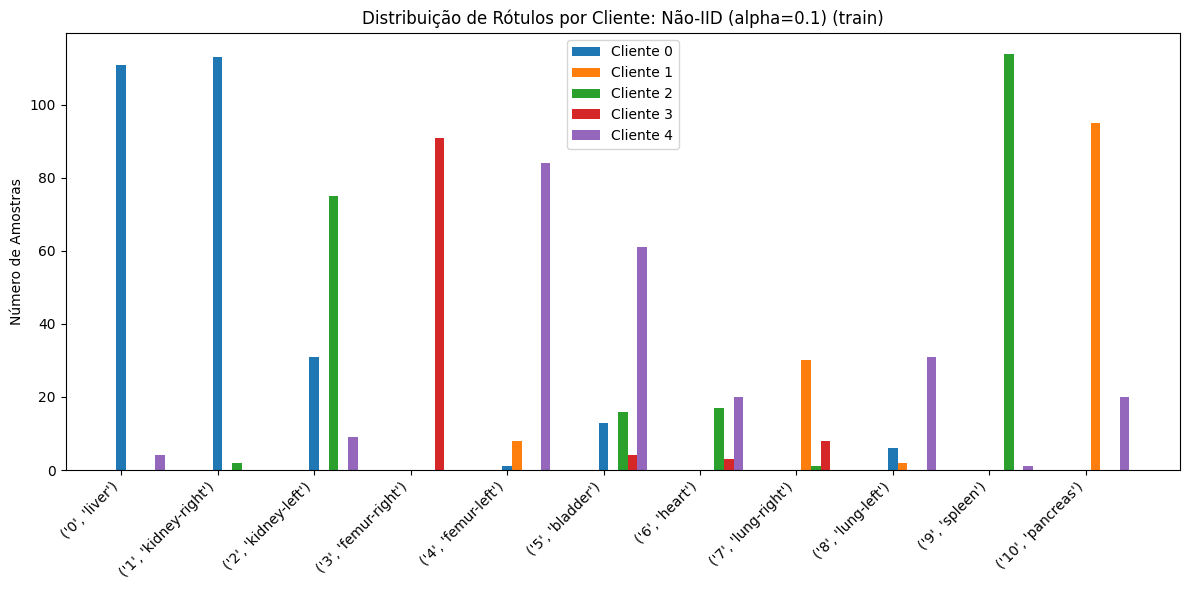

In [4]:
plot_distribution(iid=False, alpha=ALPHA)


In [5]:

def client_fn(context: Context) -> Client:
    """Cria um Flower client para um dado client ID."""
    net = Net().to(DEVICE)
    # Cada cliente recebe seu próprio DataLoader de treino
    partition_id = context.node_config['partition-id']
    num_partitions = context.node_config['num-partitions']

    train_loader, val_loader, _ = load_data_niid(partition_id=partition_id, num_partitions=num_partitions, transforms=ToTensor(), alpha=ALPHA)
    
    return FlowerClient(partition_id, net, train_loader, val_loader).to_client()


In [6]:
from medical_fl.utils import write_history

def weighted_fit_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    losses = [num_examples * m["loss"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    accuracy = sum(accuracies) / sum(examples)
    loss = sum(losses) / sum(examples)

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": accuracy}

def weighted_eval_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    losses = [num_examples * m["loss"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    accuracy = sum(accuracies) / sum(examples)
    loss = sum(losses) / sum(examples)

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": accuracy}

In [7]:
client = ClientApp(client_fn=client_fn)

In [8]:
def fit_config(server_round: int):
    """Return training configuration dict for each round

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,
        "local_epochs": 3,
        }
    return config

def eval_config(server_round: int):
    config = {
        "server_round": server_round,
        }
    return config
    

params = get_parameters(Net())

def server_fn(context: Context) -> ServerAppComponents:
    # min_available = context.run_node('min-available-clients')
    strategy = ScaffoldStrategy(
        fraction_fit = 1,
        fraction_evaluate = 1,
        min_fit_clients = 3,
        min_evaluate_clients = 3,
        min_available_clients = NUM_PARTITIONS,
        initial_parameters = ndarrays_to_parameters(params),
        evaluate_fn=evaluate,
        on_fit_config_fn=fit_config,
        on_evaluate_config_fn=eval_config,
        fit_metrics_aggregation_fn=weighted_fit_average,
        evaluate_metrics_aggregation_fn=weighted_eval_average,
    )
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [9]:
# 6. Início da Simulação
NUM_CLIENTS = NUM_PARTITIONS

backend_config = {"client_resources": None}
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1}}

# Iniciar a simulação
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


INFO :      initial parameters (loss, other metrics): 0.07858355045318603, {'accuracy': 0.11311475409836065}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.07858355045318603 / accuracy 0.11311475409836065
(ClientAppActor pid=389628) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (1, 0.07826330739943707, {'accuracy': 0.11311475409836065}, 8.490735263912939)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.07826330739943707 / accuracy 0.11311475409836065
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 1}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 1}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 1}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 1}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 1}
(ClientAppActor pid=389628) [Client 0, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (2, 0.07748846499646296, {'accuracy': 0.1819672131147541}, 13.988378648995422)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.07748846499646296 / accuracy 0.1819672131147541
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 2}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 2}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 2}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 2}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 2}
(ClientAppActor pid=389628) [Client 0, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 3] fit, config: {'server_round': 3, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (3, 0.07680343565393667, {'accuracy': 0.20491803278688525}, 19.382425830932334)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.07680343565393667 / accuracy 0.20491803278688525
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 3}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 3}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 3}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 3}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 3}
(ClientAppActor pid=389628) [Client 0, round 4] fit, config: {'server_round': 4, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 4] fit, config: {'server_round': 4, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 4] fit, config: {'server_round': 4, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 4] fit, config: {'server_round': 4, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 4] fit, config: {'server_round': 4, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (4, 0.07601672156912381, {'accuracy': 0.2836065573770492}, 24.7739936549915)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.07601672156912381 / accuracy 0.2836065573770492
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 4}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 4}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 4}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 4}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 4}
(ClientAppActor pid=389628) [Client 0, round 5] fit, config: {'server_round': 5, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 5] fit, config: {'server_round': 5, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 5] fit, config: {'server_round': 5, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (5, 0.07513885849811992, {'accuracy': 0.26885245901639343}, 30.275271993945353)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.07513885849811992 / accuracy 0.26885245901639343
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 5}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 5}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 5}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 5}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 5}
(ClientAppActor pid=389628) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 6] fit, config: {'server_round': 6, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 6] fit, config: {'server_round': 6, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 6] fit, config: {'server_round': 6, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 6] fit, config: {'server_round': 6, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (6, 0.0748537790579874, {'accuracy': 0.30983606557377047}, 35.76847056590486)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.0748537790579874 / accuracy 0.30983606557377047
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 6}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 6}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 6}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 6}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 6}
(ClientAppActor pid=389628) [Client 0, round 7] fit, config: {'server_round': 7, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 7] fit, config: {'server_round': 7, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 7] fit, config: {'server_round': 7, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 7] fit, config: {'server_round': 7, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 7] fit, config: {'server_round': 7, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (7, 0.07366891024542636, {'accuracy': 0.34262295081967215}, 41.262491618981585)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.07366891024542636 / accuracy 0.34262295081967215
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 7}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 7}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 7}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 7}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 7}
(ClientAppActor pid=389628) [Client 0, round 8] fit, config: {'server_round': 8, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 8] fit, config: {'server_round': 8, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 8] fit, config: {'server_round': 8, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 8] fit, config: {'server_round': 8, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 8] fit, config: {'server_round': 8, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (8, 0.0728708239852405, {'accuracy': 0.36721311475409835}, 46.75350954895839)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.0728708239852405 / accuracy 0.36721311475409835
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 8}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 8}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 8}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 8}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 8}
(ClientAppActor pid=389628) [Client 0, round 9] fit, config: {'server_round': 9, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 9] fit, config: {'server_round': 9, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 9] fit, config: {'server_round': 9, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 9] fit, config: {'server_round': 9, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 9] fit, config: {'server_round': 9, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (9, 0.07243530808902178, {'accuracy': 0.3983606557377049}, 52.24316368100699)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.07243530808902178 / accuracy 0.3983606557377049
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 9}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 9}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 9}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 9}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 9}
(ClientAppActor pid=389628) [Client 1, round 10] fit, config: {'server_round': 10, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 3, round 10] fit, config: {'server_round': 10, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 10] fit, config: {'server_round': 10, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 0, round 10] fit, config: {'server_round': 10, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 10] fit, config: {'server_round': 10, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

Server-side evaluation loss 0.07175968045093974 / accuracy 0.39344262295081966
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 10}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 10}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 10}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 10}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 10}
(ClientAppActor pid=389628) [Client 0, round 11] fit, config: {'server_round': 11, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 11] fit, config: {'server_round': 11, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 11] fit, config: {'server_round': 11, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 11] fit, config: {'server_round': 11, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 11] fit, config: {'server_round': 11, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (11, 0.07102514016823691, {'accuracy': 0.4065573770491803}, 63.140694244997576)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.07102514016823691 / accuracy 0.4065573770491803
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 11}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 11}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 11}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 11}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 11}
(ClientAppActor pid=389628) [Client 0, round 12] fit, config: {'server_round': 12, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 12] fit, config: {'server_round': 12, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 12] fit, config: {'server_round': 12, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 12] fit, config: {'server_round': 12, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 12] fit, config: {'server_round': 12, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (12, 0.0703915177798662, {'accuracy': 0.4278688524590164}, 68.64181232696865)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.0703915177798662 / accuracy 0.4278688524590164
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 12}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 12}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 12}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 12}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 12}
(ClientAppActor pid=389628) [Client 0, round 13] fit, config: {'server_round': 13, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 13] fit, config: {'server_round': 13, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 13] fit, config: {'server_round': 13, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 13] fit, config: {'server_round': 13, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 13] fit, config: {'server_round': 13, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (13, 0.07001666592769935, {'accuracy': 0.4344262295081967}, 74.1370577699272)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.07001666592769935 / accuracy 0.4344262295081967
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 13}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 13}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 13}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 13}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 13}
(ClientAppActor pid=389628) [Client 0, round 14] fit, config: {'server_round': 14, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 14] fit, config: {'server_round': 14, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 14] fit, config: {'server_round': 14, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 14] fit, config: {'server_round': 14, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 14] fit, config: {'server_round': 14, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (14, 0.06937947761817057, {'accuracy': 0.44754098360655736}, 79.63478122395463)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06937947761817057 / accuracy 0.44754098360655736
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 14}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 14}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 14}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 14}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 14}
(ClientAppActor pid=389628) [Client 0, round 15] fit, config: {'server_round': 15, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 15] fit, config: {'server_round': 15, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 15] fit, config: {'server_round': 15, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 15] fit, config: {'server_round': 15, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 15] fit, config: {'server_round': 15, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (15, 0.06901244452742279, {'accuracy': 0.44754098360655736}, 85.12904905900359)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06901244452742279 / accuracy 0.44754098360655736
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 15}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 15}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 15}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 15}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 15}
(ClientAppActor pid=389628) [Client 0, round 16] fit, config: {'server_round': 16, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 16] fit, config: {'server_round': 16, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 16] fit, config: {'server_round': 16, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 16] fit, config: {'server_round': 16, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 16] fit, config: {'server_round': 16, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (16, 0.06850459849248167, {'accuracy': 0.4540983606557377}, 90.62126348994207)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06850459849248167 / accuracy 0.4540983606557377
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 16}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 16}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 16}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 16}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 16}
(ClientAppActor pid=389628) [Client 0, round 17] fit, config: {'server_round': 17, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 17] fit, config: {'server_round': 17, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 17] fit, config: {'server_round': 17, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 17] fit, config: {'server_round': 17, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 17] fit, config: {'server_round': 17, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (17, 0.06824687172154911, {'accuracy': 0.45901639344262296}, 96.12188791297376)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06824687172154911 / accuracy 0.45901639344262296
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 17}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 17}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 17}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 17}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 17}
(ClientAppActor pid=389628) [Client 0, round 18] fit, config: {'server_round': 18, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 18] fit, config: {'server_round': 18, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 18] fit, config: {'server_round': 18, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 18] fit, config: {'server_round': 18, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 18] fit, config: {'server_round': 18, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (18, 0.06785569503659107, {'accuracy': 0.4672131147540984}, 101.62070230895188)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06785569503659107 / accuracy 0.4672131147540984
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 18}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 18}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 18}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 18}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 18}
(ClientAppActor pid=389628) [Client 0, round 19] fit, config: {'server_round': 19, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 19] fit, config: {'server_round': 19, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 19] fit, config: {'server_round': 19, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 19] fit, config: {'server_round': 19, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 19] fit, config: {'server_round': 19, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (19, 0.06775227433345357, {'accuracy': 0.4704918032786885}, 107.11391986499075)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06775227433345357 / accuracy 0.4704918032786885
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 19}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 19}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 19}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 19}
(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 19}
(ClientAppActor pid=389628) [Client 0, round 20] fit, config: {'server_round': 20, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 20] fit, config: {'server_round': 20, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 20] fit, config: {'server_round': 20, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 20] fit, config: {'server_round': 20, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 20] fit, config: {'server_round': 20, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (20, 0.06723036023437, {'accuracy': 0.46885245901639344}, 112.60988942696713)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06723036023437 / accuracy 0.46885245901639344
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 20}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 20}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 20}
(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 20}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 20}
(ClientAppActor pid=389628) [Client 0, round 21] fit, config: {'server_round': 21, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 21] fit, config: {'server_round': 21, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 21] fit, config: {'server_round': 21, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 21] fit, config: {'server_round': 21, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 21] fit, config: {'server_round': 21, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (21, 0.0668268895540081, {'accuracy': 0.47540983606557374}, 118.00281590595841)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.0668268895540081 / accuracy 0.47540983606557374
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 21}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 21}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 21}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 21}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 21}
(ClientAppActor pid=389628) [Client 0, round 22] fit, config: {'server_round': 22, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 22] fit, config: {'server_round': 22, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 22] fit, config: {'server_round': 22, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 22] fit, config: {'server_round': 22, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 22] fit, config: {'server_round': 22, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (22, 0.06653681465836822, {'accuracy': 0.4704918032786885}, 123.39681323897094)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06653681465836822 / accuracy 0.4704918032786885
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 22}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 22}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 22}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 22}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 22}
(ClientAppActor pid=389628) [Client 0, round 23] fit, config: {'server_round': 23, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 23] fit, config: {'server_round': 23, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 23] fit, config: {'server_round': 23, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 23] fit, config: {'server_round': 23, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 23] fit, config: {'server_round': 23, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (23, 0.06621190876257224, {'accuracy': 0.47540983606557374}, 128.89087840600405)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06621190876257224 / accuracy 0.47540983606557374
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 23}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 23}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 23}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 23}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 23}
(ClientAppActor pid=389628) [Client 0, round 24] fit, config: {'server_round': 24, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 24] fit, config: {'server_round': 24, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 24] fit, config: {'server_round': 24, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 24] fit, config: {'server_round': 24, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 24] fit, config: {'server_round': 24, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (24, 0.06598648731825782, {'accuracy': 0.4786885245901639}, 134.38909800199326)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06598648731825782 / accuracy 0.4786885245901639
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 24}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 24}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 24}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 24}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 24}
(ClientAppActor pid=389628) [Client 0, round 25] fit, config: {'server_round': 25, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 25] fit, config: {'server_round': 25, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 25] fit, config: {'server_round': 25, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 25] fit, config: {'server_round': 25, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 25] fit, config: {'server_round': 25, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (25, 0.06580372911984803, {'accuracy': 0.4786885245901639}, 139.88863868592307)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06580372911984803 / accuracy 0.4786885245901639
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 25}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 25}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 25}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 25}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 25}
(ClientAppActor pid=389628) [Client 0, round 26] fit, config: {'server_round': 26, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 26] fit, config: {'server_round': 26, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 26] fit, config: {'server_round': 26, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 26] fit, config: {'server_round': 26, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 26] fit, config: {'server_round': 26, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (26, 0.06574111883757544, {'accuracy': 0.4885245901639344}, 145.38526842696592)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06574111883757544 / accuracy 0.4885245901639344
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 26}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 26}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 26}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 26}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 26}
(ClientAppActor pid=389628) [Client 0, round 27] fit, config: {'server_round': 27, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 27] fit, config: {'server_round': 27, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 27] fit, config: {'server_round': 27, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 27] fit, config: {'server_round': 27, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 27] fit, config: {'server_round': 27, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (27, 0.06567470519269099, {'accuracy': 0.4967213114754098}, 150.87884311995003)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06567470519269099 / accuracy 0.4967213114754098
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 27}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 27}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 27}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 27}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 27}
(ClientAppActor pid=389628) [Client 0, round 28] fit, config: {'server_round': 28, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 28] fit, config: {'server_round': 28, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 28] fit, config: {'server_round': 28, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 28] fit, config: {'server_round': 28, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 28] fit, config: {'server_round': 28, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (28, 0.06574350654101763, {'accuracy': 0.49508196721311476}, 156.37448319594841)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06574350654101763 / accuracy 0.49508196721311476
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 28}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 28}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 28}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 28}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 28}
(ClientAppActor pid=389628) [Client 0, round 29] fit, config: {'server_round': 29, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 29] fit, config: {'server_round': 29, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 29] fit, config: {'server_round': 29, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 29] fit, config: {'server_round': 29, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 29] fit, config: {'server_round': 29, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (29, 0.06557383126899845, {'accuracy': 0.4934426229508197}, 161.86880183394533)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06557383126899845 / accuracy 0.4934426229508197
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 29}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 29}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 29}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 29}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 29}
(ClientAppActor pid=389628) [Client 0, round 30] fit, config: {'server_round': 30, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 30] fit, config: {'server_round': 30, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 30] fit, config: {'server_round': 30, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 30] fit, config: {'server_round': 30, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 30] fit, config: {'server_round': 30, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (30, 0.06598422214633129, {'accuracy': 0.49836065573770494}, 167.36199427000247)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06598422214633129 / accuracy 0.49836065573770494
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 30}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 30}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 30}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 30}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 30}
(ClientAppActor pid=389628) [Client 0, round 31] fit, config: {'server_round': 31, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 31] fit, config: {'server_round': 31, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 31] fit, config: {'server_round': 31, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 31] fit, config: {'server_round': 31, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 31] fit, config: {'server_round': 31, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (31, 0.06536034052489234, {'accuracy': 0.4967213114754098}, 172.851810817956)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06536034052489234 / accuracy 0.4967213114754098
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 31}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 31}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 31}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 31}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 31}
(ClientAppActor pid=389628) [Client 0, round 32] fit, config: {'server_round': 32, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 32] fit, config: {'server_round': 32, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 32] fit, config: {'server_round': 32, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 32] fit, config: {'server_round': 32, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 32] fit, config: {'server_round': 32, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (32, 0.06580338614885925, {'accuracy': 0.5032786885245901}, 178.35073611093685)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06580338614885925 / accuracy 0.5032786885245901
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 32}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 32}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 32}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 32}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 32}
(ClientAppActor pid=389628) [Client 0, round 33] fit, config: {'server_round': 33, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 33] fit, config: {'server_round': 33, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 33] fit, config: {'server_round': 33, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 33] fit, config: {'server_round': 33, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 33] fit, config: {'server_round': 33, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (33, 0.06509526362184619, {'accuracy': 0.49836065573770494}, 183.84395452192985)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06509526362184619 / accuracy 0.49836065573770494
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 33}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 33}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 33}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 33}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 33}
(ClientAppActor pid=389628) [Client 0, round 34] fit, config: {'server_round': 34, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 34] fit, config: {'server_round': 34, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 34] fit, config: {'server_round': 34, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 34] fit, config: {'server_round': 34, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 34] fit, config: {'server_round': 34, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (34, 0.065327217735228, {'accuracy': 0.5016393442622951}, 189.33626107894816)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.065327217735228 / accuracy 0.5016393442622951
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 34}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 34}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 34}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 34}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 34}
(ClientAppActor pid=389628) [Client 0, round 35] fit, config: {'server_round': 35, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 35] fit, config: {'server_round': 35, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 35] fit, config: {'server_round': 35, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 35] fit, config: {'server_round': 35, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 35] fit, config: {'server_round': 35, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (35, 0.06500028274098381, {'accuracy': 0.4967213114754098}, 194.8305205180077)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06500028274098381 / accuracy 0.4967213114754098
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 35}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 35}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 35}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 35}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 35}
(ClientAppActor pid=389628) [Client 0, round 36] fit, config: {'server_round': 36, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 36] fit, config: {'server_round': 36, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 36] fit, config: {'server_round': 36, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 36] fit, config: {'server_round': 36, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 36] fit, config: {'server_round': 36, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (36, 0.06506837450090001, {'accuracy': 0.5016393442622951}, 200.32207027391996)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06506837450090001 / accuracy 0.5016393442622951
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 36}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 36}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 36}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 36}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 36}
(ClientAppActor pid=389628) [Client 0, round 37] fit, config: {'server_round': 37, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 37] fit, config: {'server_round': 37, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 37] fit, config: {'server_round': 37, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 37] fit, config: {'server_round': 37, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 37] fit, config: {'server_round': 37, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (37, 0.06474278344482672, {'accuracy': 0.5032786885245901}, 205.82179949595593)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06474278344482672 / accuracy 0.5032786885245901
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 37}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 37}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 37}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 37}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 37}
(ClientAppActor pid=389628) [Client 0, round 38] fit, config: {'server_round': 38, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 38] fit, config: {'server_round': 38, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 38] fit, config: {'server_round': 38, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 38] fit, config: {'server_round': 38, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 38] fit, config: {'server_round': 38, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (38, 0.06506165305122, {'accuracy': 0.5114754098360655}, 211.319009084953)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06506165305122 / accuracy 0.5114754098360655
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 38}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 38}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 38}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 38}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 38}
(ClientAppActor pid=389628) [Client 0, round 39] fit, config: {'server_round': 39, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 39] fit, config: {'server_round': 39, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 39] fit, config: {'server_round': 39, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 39] fit, config: {'server_round': 39, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 39] fit, config: {'server_round': 39, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (39, 0.064931598452271, {'accuracy': 0.5098360655737705}, 216.81060894799884)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.064931598452271 / accuracy 0.5098360655737705
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 39}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 39}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 39}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 39}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 39}
(ClientAppActor pid=389628) [Client 0, round 40] fit, config: {'server_round': 40, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 40] fit, config: {'server_round': 40, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 3, round 40] fit, config: {'server_round': 40, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 40] fit, config: {'server_round': 40, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 40] fit, config: {'server_round': 40, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

Server-side evaluation loss 0.06467952356963862 / accuracy 0.5180327868852459
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 40}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 40}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 40}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 40}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 40}
(ClientAppActor pid=389628) [Client 0, round 41] fit, config: {'server_round': 41, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 41] fit, config: {'server_round': 41, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 41] fit, config: {'server_round': 41, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 41] fit, config: {'server_round': 41, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 41] fit, config: {'server_round': 41, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (41, 0.06485433949798834, {'accuracy': 0.5098360655737705}, 227.7096242979169)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06485433949798834 / accuracy 0.5098360655737705
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 41}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 41}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 41}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 41}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 41}
(ClientAppActor pid=389628) [Client 0, round 42] fit, config: {'server_round': 42, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 42] fit, config: {'server_round': 42, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 42] fit, config: {'server_round': 42, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 42] fit, config: {'server_round': 42, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 42] fit, config: {'server_round': 42, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (42, 0.06341822870442125, {'accuracy': 0.5229508196721312}, 233.20325407991186)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06341822870442125 / accuracy 0.5229508196721312
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 42}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 42}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 42}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 42}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 42}
(ClientAppActor pid=389628) [Client 0, round 43] fit, config: {'server_round': 43, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 43] fit, config: {'server_round': 43, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 43] fit, config: {'server_round': 43, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 43] fit, config: {'server_round': 43, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 43] fit, config: {'server_round': 43, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (43, 0.06294833968897334, {'accuracy': 0.5180327868852459}, 238.69697186199483)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06294833968897334 / accuracy 0.5180327868852459
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 43}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 43}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 43}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 43}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 43}
(ClientAppActor pid=389628) [Client 0, round 44] fit, config: {'server_round': 44, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 44] fit, config: {'server_round': 44, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 44] fit, config: {'server_round': 44, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 44] fit, config: {'server_round': 44, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 44] fit, config: {'server_round': 44, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (44, 0.06510032317677482, {'accuracy': 0.5245901639344263}, 244.19058521301486)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06510032317677482 / accuracy 0.5245901639344263
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 44}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 44}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 44}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 44}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 44}
(ClientAppActor pid=389628) [Client 0, round 45] fit, config: {'server_round': 45, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 45] fit, config: {'server_round': 45, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 45] fit, config: {'server_round': 45, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 45] fit, config: {'server_round': 45, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 45] fit, config: {'server_round': 45, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (45, 0.0650482816774337, {'accuracy': 0.5278688524590164}, 249.68564826098736)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.0650482816774337 / accuracy 0.5278688524590164
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 45}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 45}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 45}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 45}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 45}
(ClientAppActor pid=389628) [Client 0, round 46] fit, config: {'server_round': 46, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 46] fit, config: {'server_round': 46, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 46] fit, config: {'server_round': 46, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 46] fit, config: {'server_round': 46, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 46] fit, config: {'server_round': 46, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (46, 0.06535555397877928, {'accuracy': 0.5278688524590164}, 255.18337538500782)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06535555397877928 / accuracy 0.5278688524590164
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 46}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 46}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 46}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 46}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 46}
(ClientAppActor pid=389628) [Client 0, round 47] fit, config: {'server_round': 47, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 47] fit, config: {'server_round': 47, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 47] fit, config: {'server_round': 47, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 47] fit, config: {'server_round': 47, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 47] fit, config: {'server_round': 47, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (47, 0.06273491792991513, {'accuracy': 0.5131147540983606}, 260.67814986093435)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06273491792991513 / accuracy 0.5131147540983606
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 47}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 47}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 47}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 47}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 47}
(ClientAppActor pid=389628) [Client 0, round 48] fit, config: {'server_round': 48, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 48] fit, config: {'server_round': 48, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 48] fit, config: {'server_round': 48, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 48] fit, config: {'server_round': 48, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 48] fit, config: {'server_round': 48, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (48, 0.0644303593479219, {'accuracy': 0.5278688524590164}, 266.1731138009345)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.0644303593479219 / accuracy 0.5278688524590164
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 48}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 48}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 48}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 48}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 48}
(ClientAppActor pid=389628) [Client 0, round 49] fit, config: {'server_round': 49, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 49] fit, config: {'server_round': 49, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 49] fit, config: {'server_round': 49, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 49] fit, config: {'server_round': 49, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 49] fit, config: {'server_round': 49, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (49, 0.06582948125776697, {'accuracy': 0.5360655737704918}, 271.86872305197176)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06582948125776697 / accuracy 0.5360655737704918
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 49}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 49}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 49}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 49}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 49}
(ClientAppActor pid=389628) [Client 0, round 50] fit, config: {'server_round': 50, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 1, round 50] fit, config: {'server_round': 50, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 2, round 50] fit, config: {'server_round': 50, 'local_epochs': 3}


ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=389628, ip=143.106.45.41, actor_id=9c0f5c9886c9dfeea59fd7cc01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7fe0b1bc1f10>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/client_app.py", line 128, in ffn
    out_message = handle_legacy_message_from_msgtype(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/miniconda3/envs/flwr/lib/python3.12/site-packages/flwr/client/message_handler/message_handler.py", line 128, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
              ^^^^^^^^^^^^^^^
  File "/home/a

(ClientAppActor pid=389628) [Client 3, round 50] fit, config: {'server_round': 50, 'local_epochs': 3}
(ClientAppActor pid=389628) [Client 4, round 50] fit, config: {'server_round': 50, 'local_epochs': 3}


INFO :      aggregate_fit: received 4 results and 1 failures
INFO :      fit progress: (50, 0.06562654718023832, {'accuracy': 0.5426229508196722}, 277.3563485490158)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


Server-side evaluation loss 0.06562654718023832 / accuracy 0.5426229508196722
(ClientAppActor pid=389628) [Client 0] evaluate, config: {'server_round': 50}
(ClientAppActor pid=389628) [Client 1] evaluate, config: {'server_round': 50}
(ClientAppActor pid=389628) [Client 2] evaluate, config: {'server_round': 50}
(ClientAppActor pid=389628) [Client 3] evaluate, config: {'server_round': 50}


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 278.76s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0443391918395617
INFO :      		round 2: 0.04247892569310917
INFO :      		round 3: 0.040224250058950105
INFO :      		round 4: 0.04042031898261597
INFO :      		round 5: 0.037917823524948976
INFO :      		round 6: 0.03681288002440648
INFO :      		round 7: 0.03493986070526313
INFO :      		round 8: 0.034851305233025404
INFO :      		round 9: 0.03180873319969414
INFO :      		round 10: 0.032060471380719484
INFO :      		round 11: 0.0299211947814278
INFO :      		round 12: 0.030244256398692635
INFO :      		round 13: 0.02900528463517657
INFO :      		round 14: 0.026757798579909047
INFO :      		round 15: 0.027189780466304804
INFO :      		round 16: 0.02669128201763082
INFO :      		round 17: 0.024947252332794
INFO :      		round 18: 0.022685359723819708
INFO :      		round 19

(ClientAppActor pid=389628) [Client 4] evaluate, config: {'server_round': 50}
